This notebook analyses the pubmed search terms

**Neuroscience AND Personality**

In [1]:
terms = "Neuroscience AND Personality"

In [2]:
# imports

# region wise analysis imports
import folium
from folium.plugins import MarkerCluster

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# topic analysis imports and word cloud imports
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
import re
import numpy as np
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud

# sns plots

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# network visualization

from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot


In [3]:
# EDIT THIS CELL

pre_cleaned_processed_db = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/neuroscience_personality/ready_NEU_PER_DF_pre_cleaned_processed"
big_df = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/neuroscience_personality/uni_NEU_PER_DF_bigdf"

img_name = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/neuroscience_personality/uni_NEU_PER_DF_word_cloud.jpeg"
circ_name = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/neuroscience_personality/uni_NEU_PER_DF_bigdf_circ.jpeg"

In [4]:
# DB imports
countries_dataframe = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/countries_2"


# Region wise analysis

In [5]:
# notebook 4_primary_analyses_country_wise
df_n = pd.read_csv(pre_cleaned_processed_db)

# geographical coods
coods = df_n.loc[:, ['code', 'latitude', 'longitude']]
coods = coods.drop_duplicates(subset=['code'], keep='first')

# country wise stats
x_country = df_n.groupby(['code']).size().reset_index(name='country_count')
x_country = pd.merge(x_country, coods, left_on='code', right_on='code')



### Continent wise summary

In [6]:
# continent wise stats

# country info
iso_info = pd.read_csv(countries_dataframe)

x_continent = pd.merge(x_country, iso_info, left_on='code', right_on='code')

del x_continent['timezones']
del x_continent['capital']

y_x = x_continent.groupby('continent', as_index=False)['country_count'].sum()

y_y = x_continent.groupby('continent', as_index=False)['latitude'].mean()

y_z = x_continent.groupby('continent', as_index=False)['longitude'].mean()
y_continent = pd.merge(pd.merge(y_x,y_y,on='continent'),y_z,on='continent')

# drop NAs

x_continent = x_continent[x_continent['latitude'].notna()]
x_continent = x_continent[x_continent['longitude'].notna()]

# normalise counts
x_continent["country_count_norm"] = x_continent["country_count"] / x_continent["country_count"].max()

# continent summary
y_continent

,continent,country_count,latitude,longitude
0,Africa,21,-3.147650,25.572374
1,Asia,35,31.626758,70.589430
2,Europe,389,49.294870,11.276038
3,North America,58,31.264302,-89.888027
4,Oceania,71,-33.087477,154.330553
5,South America,6,-16.922615,-68.957003


In [7]:

# Create a world map to show distributions of researchers and their contributions

#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(x_continent)):
        lat = x_continent.iloc[i]['latitude']
        long = x_continent.iloc[i]['longitude']
        radius = float(x_continent.iloc[i]['country_count_norm'])*100# bubble map parameter
        popup_text = """continent : {}<br>
                    a) total contributions for the given topic : {}
                    b) percentage contribution : {} % <br>"""
        popup_text = popup_text.format(x_continent.iloc[i]['name'],
                                   x_continent.iloc[i]['country_count'], 
                                       round(x_continent.iloc[i]['country_count_norm']*100, 2)
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

### Top 20 major contributors

The country_count column represents number of researchers affiliated with a given country/ institute in a country.

In [8]:
stats = x_continent
stats.sort_values("country_count_norm", inplace=True, ascending=False)
del stats['latitude']
del stats['longitude']
stats.head(n=20)

,code,country_count,continent,name,country_count_norm
12,DE,107,Europe,Germany,1.000000
14,ES,76,Europe,Spain,0.710280
2,AU,67,Oceania,Australia,0.626168
39,US,42,North America,United States,0.392523
24,IT,35,Europe,Italy,0.327103
9,CH,34,Europe,Switzerland,0.317757
37,SE,32,Europe,Sweden,0.299065
31,NL,30,Europe,Kingdom of the Netherlands,0.280374
17,FR,24,Europe,France,0.224299
8,CA,13,North America,Canada,0.121495


# Topic analyses of the papers

In [9]:

# Load in the final processed dataframe i.e. BIG_DF
df = pd.read_csv(big_df)

papers = df.loc[:, ['doi', 'year', 'title', 'abstract', 'author', 'affiliation_y', 'country', 'fuzzy_matched_QS']]
abstracts = papers.groupby(['abstract'], as_index=False, sort=False).agg(' | '.join)
abstracts.head(1)

/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,abstract,title,author,affiliation_y,country,fuzzy_matched_QS
0,Accumulating neuroscience evidence indicates t...,Lesion mapping of social problem solving. | Le...,Aron K Barbey | Erick J Paul | Aron K Ba...,Decision Neuroscience Laboratory University of...,United States | United States | United States ...,Massachusetts Institute of Technology (MIT) | ...


In [10]:
print("Total {} abstracts are available for the terms {}.".format(len(abstracts), terms))

Total 73 abstracts are available for the terms Neuroscience AND Personality.


In [11]:
## PREPROCESSING
#Removing symbols from Abstracts
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)

# tokenization
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: (word_tokenize(row['Abstract_Cleaned'])), axis = 1)

# we have to remove stopwords
stop_words = set(stopwords.words('english'))
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

copy = abstracts

# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(abstracts['Abstract_Cleaned'])
texts = abstracts['Abstract_Cleaned']
corpus = [dictionary.doc2bow(text) for text in abstracts['Abstract_Cleaned']]

# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## INVERSE DOCUMENT FREQUENCIES FOR TOPICS

# inverse document frequencies for topics

abstracts = copy['abstract'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

# Mapping Top Topics & Abstracts

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

# Affinity propogation on abstracts
#Testing affinity propogation on abstracts tfidf(experimental)

X = tfidf_abstracts
clustering = AffinityPropagation().fit(X)


# Building LDA Model

lda_model_17 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# visualization

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_17, corpus, dictionary)
vis

/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.054492  0.069175       1        1  12.633828
8      0.053600  0.020270       2        1   7.499767
12     0.130866 -0.060445       3        1   7.465535
10     0.060802  0.101426       4        1   7.452248
6     -0.021863  0.120692       5        1   6.851057
13     0.113090  0.091214       6        1   6.691763
15    -0.053650 -0.005624       7        1   5.874179
16    -0.077315 -0.075996       8        1   5.817177
3     -0.066502  0.008627       9        1   5.702324
14     0.031319 -0.050927      10        1   5.598894
11    -0.129902  0.006040      11        1   5.537423
1      0.046555  0.062677      12        1   4.505899
2     -0.072377 -0.055660      13        1   4.308398
0      0.045216 -0.065655      14        1   4.017769
5     -0.085555  0.024450      15        1   3.922295
4      0.028902 -0.062536      16        1   3.469445
7      0.051303 -0.127728      17        1   2.651999, topic_info=           Term       Freq      Total Category  logprob  loglift
270        risk  41.000000  41.000000  Default  30.0000  30.0000
461        self  36.000000  36.000000  Default  29.0000  29.0000
208           0  55.000000  55.000000  Default  28.0000  28.0000
111     symptom  41.000000  41.000000  Default  27.0000  27.0000
1625   learning  23.000000  23.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
179     measure   1.284540  12.335466  Topic17  -5.4594   1.3678
33    behaviour   1.288862  24.074047  Topic17  -5.4561   0.7025
59         goal   1.280421  16.269481  Topic17  -5.4627   1.0878
164     finding   1.272895  23.872343  Topic17  -5.4686   0.6984
494      cohort   1.269928  10.925070  Topic17  -5.4709   1.4778

[1039 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
285       1  0.211463      '
285       2  0.035244      '
285       3  0.105732      '
285       4  0.035244      '
285       7  0.105732      '
...     ...       ...    ...
682      12  0.043085   year
682      13  0.043085   year
682      15  0.215424   year
682      16  0.043085   year
954      10  0.917229  youth

[2211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 13, 11, 7, 14, 16, 17, 4, 15, 12, 2, 3, 1, 6, 5, 8])

Let's map the top matching topics with top matching abstracts, to generate a list of relevant papers.

In [12]:

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

# first remove duplicated title, which was due to grouping the dataframe

c_c = copy['title'].str.split("|", 1, expand=True)
copy['title'] = c_c[0]
copy.head()

def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('\n',"Topic %d:" % (topic_idx))
        print("Top Words: "," ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            
no_top_words = 15
no_top_documents = 4     
title_list = copy['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
#display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)


nmf_model = NMF(n_components=9, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_abstracts)
nmf_W = nmf_model.transform(tfidf_abstracts)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, tf_feature_names, title_list, no_top_words, no_top_documents)



 Topic 0:
Top Words:  the and of in to with for that is on was between were cognitive we
Gene-environment interaction of monoamine oxidase A in relation to antisocial behaviour: current and future directions. 
Idiographic analyses of motivation and related processes in participants with schizophrenia following a therapeutic intervention for negative symptoms. 
Social support mediates the relationships between extraversion, neuroticism, and cognitive function in older adults. 
Translational Models of Gambling-Related Decision-Making. 

 Topic 1:
Top Words:  learning avoidance approach drug cud vs styles instrumental habitual reinforcement directed goal computational formation habit
Linking Individual Learning Styles to Approach-Avoidance Motivational Traits and Computational Aspects of Reinforcement Learning. 
Impairments in reinforcement learning do not explain enhanced habit formation in cocaine use disorder. 
Contextual influence on confidence judgments in human reinforcement learni

In [13]:
print("Based on the original keywords: {}, above topics were prevalant.".format(terms))

Based on the original keywords: Neuroscience AND Personality, above topics were prevalant.


# Top 20s

In [14]:
# Load in the dataframe
df_n = pd.read_csv(pre_cleaned_processed_db)

### Top 20 affiliations

In [15]:
affiliation_grouping = df_n.groupby(['affiliation']).size().reset_index(name='affiliation_count')
affiliation_grouping.head(n=1)
stats = affiliation_grouping
stats.sort_values("affiliation_count", inplace=True, ascending=False)
stats.head(n=20)

,affiliation,affiliation_count
12,CIBER Fisiopatologa Obesidad y Nutricin CIBERO...,16
194,Human Neuropsychopharmacology Group Sant Pau I...,14
282,Translational Research Center University Hospi...,8
209,Institute of Neuroscience and Medicine INM Res...,8
200,Institute of Clinical Neuroscience and Medical...,7
211,Institute of Systems Neuroscience Medical Facu...,7
272,Stroke Division the Florey Institute of Neuros...,6
87,Department of Neuroradiology Klinikum rechts d...,6
23,Centre for Healthy Brain Ageing CHeBA School o...,6
226,Lineberger Comprehensive Cancer Center Univers...,6


### Top 20 authors

In [16]:
author_grouping = df_n.groupby(['author']).size().reset_index(name='author_count')
author_grouping.head(n=1)
stats1 = author_grouping
stats1.sort_values("author_count", inplace=True, ascending=False)
stats1.head(n=20)

,author,author_count
110,Felix Hoffstaedter,5
382,Simon B Eickhoff,4
80,Deepthi P Varikuti,3
203,Karin Bacily,3
398,Susana Jim..nez-Murcia,3
53,C Suo,3
216,Kimberly C Doell,3
393,Stefano Palminteri,3
389,Sophie Schwartz,3
371,Sarah Sauchelli,3


### Top 20 journals

In [17]:
journal_grouping = df_n.groupby(['journal']).size().reset_index(name='journal_count')
journal_grouping.head(n=1)
stats2 = journal_grouping
stats2.sort_values("journal_count", inplace=True, ascending=False)
stats2.head(n=20)

,journal,journal_count
52,PLoS One,43
59,Sci Rep,42
26,Eur Eat Disord Rev,40
14,Brain Imaging Behav,32
13,Brain,25
15,Brain Struct Funct,22
28,Eur Psychiatry,19
57,Psychopharmacology (Berl),17
43,J Telemed Telecare,16
48,Neuropsychopharmacology,15


# University wise analysis (Top 100 CN and US)

In [18]:
# Load in the dataframe
df = pd.read_csv(big_df)

/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Including only Top 100 universities from US and ChinaArc

In [19]:
# converting ranges into a solid rank
  
split_range = lambda rank : [[int(y) for y in x.split('-')] if len(x.split('-')) == 2 else [int(x.split('+')[0])] for x in rank]

df['rank display'] = split_range(df['rank display'].astype(str))
df['rank display'] = pd.DataFrame(df['rank display'].values.tolist()).mean(1)

# get top 100
top_h = df[df['rank display'] <= 100]

# only china and us
codes = ['CN', 'US']

cleaned = top_h[top_h['country code'].isin(codes)]


In [20]:
papers = cleaned.loc[:, ['doi', 'year', 'title', 'abstract', 'author', 'affiliation_y', 'country', 'fuzzy_matched_QS', 'rank display']]
papers['abstract'] = papers['abstract'].astype(str)
title = papers.groupby(['title'], as_index=False, sort=False).agg(' | '.join)

# first remove duplicated title, which was due to grouping the dataframe

c_c = title['abstract'].str.split("|", 1, expand=True)

In [21]:
print("Total {} researchers hail from United States and China".format(len(cleaned)))

Total 2616 researchers hail from United States and China


In [22]:
print('{} publications from United States and China for the terms {}.'.format(len(title), terms))

69 publications from United States and China for the terms Neuroscience AND Personality.


### Topic model for selected abstracts

#### Topic keywords

In [23]:
## PREPROCESSING
#Removing symbols from Abstracts
title['Abstract_Cleaned'] = title.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)

# tokenization
title['Abstract_Cleaned'] = title.apply(lambda row: (word_tokenize(row['Abstract_Cleaned'])), axis = 1)

# we have to remove stopwords
stop_words = set(stopwords.words('english'))
title['Abstract_Cleaned'] = title.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
title['Abstract_Cleaned'] = title.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

copy = title

# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(title['Abstract_Cleaned'])
texts = title['Abstract_Cleaned']
corpus = [dictionary.doc2bow(text) for text in title['Abstract_Cleaned']]


# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## INVERSE DOCUMENT FREQUENCIES FOR TOPICS

# inverse document frequencies for topics

title = copy['abstract'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(title)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_title = tfidf_vectorizer.transform(counts)

# Mapping Top Topics & Abstracts

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_title)
lda_W = lda_model.transform(tfidf_title)
lda_H = lda_model.components_

# Affinity propogation on title
#Testing affinity propogation on title tfidf(experimental)

X = tfidf_title
clustering = AffinityPropagation().fit(X)


# Building LDA Model

lda_model_X = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



# we need to remove these excessively obvious term to see if the abstracts truly reflect the original searched key words
more_stopwords = [
    "research",
    "study",
    "examined",
    "associated",
    "studies",
    "Recent",
    "the",
    "of",
    "in",
    "for",
    "included",
    "present",
    "examine",
    "health",
    "human",
    "Although",
    "whether",
    "suggest",
    "use",
    "used"
]

copy['Abstract_Cleaned'] = copy.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in more_stopwords]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
copy['Abstract_Cleaned'] = copy.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

lem_text = copy['Abstract_Cleaned'].to_string()


/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


In [24]:
wc1 = WordCloud(background_color="white", width=600, height=400, min_font_size=15)
wc1.generate(lem_text)
wc1.to_file(img_name)

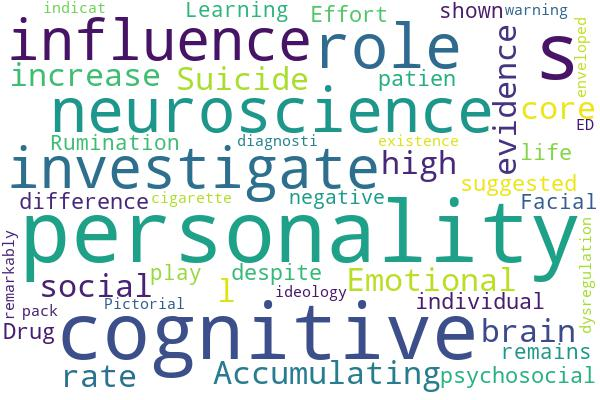

In [25]:
# visualization

pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(lda_model_X, corpus, dictionary)
vis_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.120684  0.180296       1        1  13.163572
2     -0.197412  0.092285       2        1   9.628405
0      0.039222  0.131365       3        1   8.070515
6     -0.197491 -0.058664       4        1   7.610760
7     -0.121394  0.114615       5        1   6.677919
16    -0.039627  0.230391       6        1   6.263753
8     -0.130373 -0.108313       7        1   6.212504
11     0.169498 -0.076582       8        1   6.046476
1     -0.067090 -0.125056       9        1   5.403858
13     0.064782 -0.100426      10        1   5.308328
14     0.111249 -0.032373      11        1   5.105365
9      0.130542 -0.015398      12        1   4.520217
15    -0.081611 -0.081115      13        1   4.336338
4      0.031864 -0.113284      14        1   3.951533
3      0.127839 -0.029206      15        1   3.526980
12    -0.047773 -0.050559      16        1   2.981826
10     0.087089  0.042024      17        1   1.191651, topic_info=          Term         Freq        Total Category  logprob  loglift
208          0  4470.000000  4470.000000  Default  30.0000  30.0000
539          p  2435.000000  2435.000000  Default  29.0000  29.0000
81     network  2022.000000  2022.000000  Default  28.0000  28.0000
1789  learning  1284.000000  1284.000000  Default  27.0000  27.0000
1265     sleep   891.000000   891.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
460      score    35.554345   934.748616  Topic17  -4.9093   1.1606
236     effect    37.154228  1961.466881  Topic17  -4.8653   0.4635
208          0    38.625830  4470.650424  Topic17  -4.8264  -0.3215
223          P    34.213587   952.176823  Topic17  -4.9477   1.1037
285          '    33.423886  1067.393391  Topic17  -4.9711   0.9661

[1073 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
285       1  0.021548      '
285       2  0.000937      '
285       3  0.000937      '
285       6  0.343828      '
285       7  0.000937      '
...     ...       ...    ...
556      14  0.028662   year
556      15  0.081685   year
556      16  0.308112   year
801       7  0.047343  youth
801       8  0.940092  youth

[2994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 7, 8, 17, 9, 12, 2, 14, 15, 10, 16, 5, 4, 13, 11])

#### Topic summaries

In [26]:
print("Following topics were enriched for {} abstracts from US and CN, for the terms {}.".format(len(title), terms))

Following topics were enriched for 69 abstracts from US and CN, for the terms Neuroscience AND Personality.


In [27]:

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_title)
lda_W = lda_model.transform(tfidf_title)
lda_H = lda_model.components_

def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('\n',"Topic %d:" % (topic_idx))
        print("Top Words: "," ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            
no_top_words = 15
no_top_documents = 4     
title_list = copy['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
#display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

nmf_model = NMF(n_components=9, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_title)
nmf_W = nmf_model.transform(tfidf_title)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, tf_feature_names, title_list, no_top_words, no_top_documents)



 Topic 0:
Top Words:  the and of in to with that is for on was were we as between
Gene-environment interaction of monoamine oxidase A in relation to antisocial behaviour: current and future directions.
Idiographic analyses of motivation and related processes in participants with schizophrenia following a therapeutic intervention for negative symptoms.
Translational Models of Gambling-Related Decision-Making.
Estimating everyday risk: Subjective judgments are related to objective risk, mapping of numerical magnitudes and previous experience.

 Topic 1:
Top Words:  learning avoidance approach drug cud vs styles instrumental habitual reinforcement directed goal computational formation habit
Linking Individual Learning Styles to Approach-Avoidance Motivational Traits and Computational Aspects of Reinforcement Learning.
Impairments in reinforcement learning do not explain enhanced habit formation in cocaine use disorder.
Contextual influence on confidence judgments in human reinforcement l

### Quick stats

In [28]:
publication_data = cleaned
# Let's do a quick top 10s for the given lists

sns.set_style("white")
plt.figure(figsize=(10, 10), dpi=600)



<Figure size 6000x6000 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

#### Top 10 authors from US and CN combined


Text(0.5, 1.0, 'Top 10 Authors for the search terms Neuroscience AND Personality')

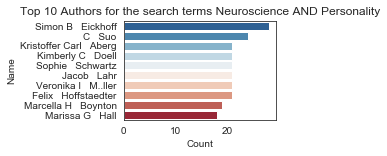

In [29]:
plt.subplot(2, 2, 1)

top10authors = pd.DataFrame.from_records(
    Counter(publication_data['author']).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors for the search terms {}".format(terms))


#### Top 10 Journals where researchers from US and CN publish

Text(0.5, 1.0, 'Top 10 Journals for the search terms Neuroscience AND Personality')

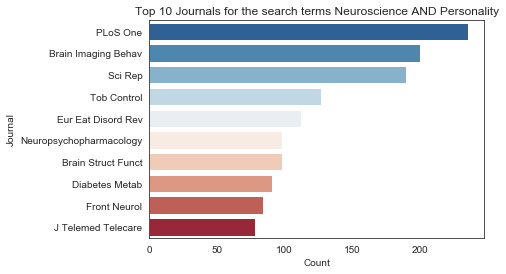

In [30]:
# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["journal"]).most_common(10),
    columns=["Journal", "Count"],
)
sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals for the search terms {}".format(terms))



#### Top 10 institutes involved

Text(0.5, 1.0, 'Top 10 Institutes for the search terms Neuroscience AND Personality')

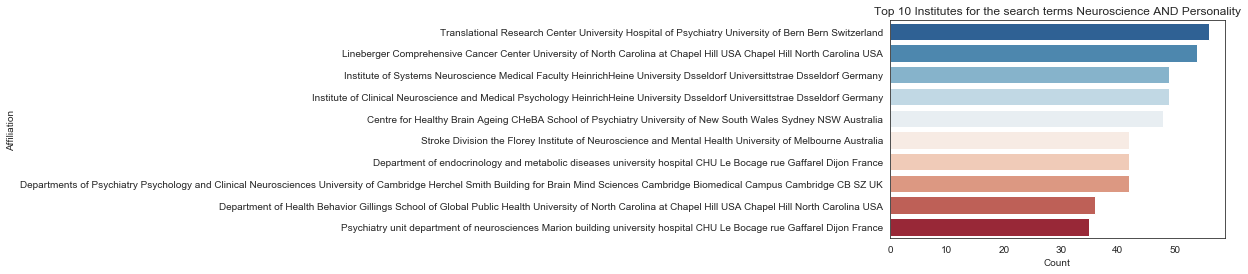

In [31]:
# TOP 10 Institutes involved
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["original_affiliation"]).most_common(10),
    columns=["Affiliation", "Count"],
)
sns.barplot(x="Count", y="Affiliation", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Institutes for the search terms {}".format(terms))


#### Contributions from ranked institutes

Text(0.5, 1.0, 'QS Ranked Institutes for the search terms Neuroscience AND Personality')

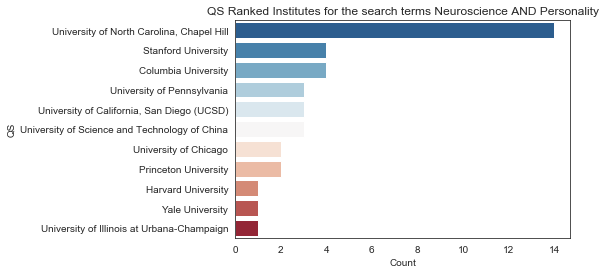

In [32]:
# Contributions from ranked institutes
high_filter = publication_data[publication_data["Token_Set_Ratio"] >= 85]
top10journals = pd.DataFrame.from_records(
    Counter(high_filter["fuzzy_matched_QS"]).most_common(),
    columns=["QS", "Count"],
)
sns.barplot(x="Count", y="QS", data=top10journals, palette="RdBu_r")
plt.title("QS Ranked Institutes for the search terms {}".format(terms))


#### Information about top 10 authors

In [33]:
group_p = publication_data.loc[:, ['pmid', 'year', 'title', 'abstract', 'author', 'original_affiliation', 'fuzzy_matched_QS', 'rank display']]
group_p["pmid"] = group_p["pmid"].astype(str)
group_p = group_p.groupby(['author'], as_index=False, sort=False).agg(' | '.join)
top_10_info = pd.merge(top10authors, group_p, left_on='Name', right_on='author')
del top_10_info["Name"]
del top_10_info["abstract"]
top_10_info

,Count,author,pmid,title,original_affiliation,fuzzy_matched_QS
0,28,Simon B Eickhoff,29572625 | 29572625 | 30864950 | 30864950 | 29...,Predicting personality from network-based rest...,Institute of Clinical Neuroscience and Medical...,Cornell University | Cornell University | Corn...
1,24,C Suo,27848149 | 27848149 | 27848149 | 27848149 | 27...,Midlife managerial experience is linked to lat...,School of Psychiatry University of New South W...,Cornell University | Cornell University | Corn...
2,21,Kristoffer Carl Aberg,27851807 | 27851807 | 27851807 | 27851807 | 27...,Linking Individual Learning Styles to Approach...,Department of Neuroscience Faculty of Medicine...,Cornell University | Cornell University | Corn...
3,21,Kimberly C Doell,27851807 | 27851807 | 27851807 | 27851807 | 27...,Linking Individual Learning Styles to Approach...,Swiss Center for Affective Sciences University...,Cornell University | Cornell University | Corn...
4,21,Sophie Schwartz,27851807 | 27851807 | 27851807 | 27851807 | 27...,Linking Individual Learning Styles to Approach...,Geneva Neuroscience Center University of Genev...,Cornell University | Cornell University | Corn...
5,21,Jacob Lahr,29915555 | 29915555 | 29915555 | 29915555 | 29...,Working Memory-Related Effective Connectivity ...,Department of Psychology Laboratory for Biolog...,Cornell University | Cornell University | Corn...
6,21,Veronika I M..ller,29572625 | 29572625 | 29572625 | 29572625 | 29...,Predicting personality from network-based rest...,Institute of Systems Neuroscience Medical Facu...,Cornell University | Cornell University | Corn...
7,21,Felix Hoffstaedter,29572625 | 29572625 | 29572625 | 29572625 | 29...,Predicting personality from network-based rest...,Institute of Clinical Neuroscience and Medical...,Cornell University | Cornell University | Corn...
8,19,Marcella H Boynton,29248897 | 29248897 | 29248897 | 29248897 | 29...,"Negative affect, message reactance and perceiv...",Stanford Prevention Research Center Stanford U...,Stanford University | Cornell University | Cor...
9,18,Marissa G Hall,29248897 | 29248897 | 29248897 | 29248897 | 29...,"Negative affect, message reactance and perceiv...",Lineberger Comprehensive Cancer Center Univers...,Cornell University | Cornell University | Peki...


#### Publications for the give terms over time

(2010, 2020)

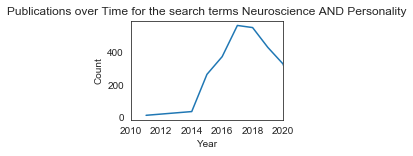

In [34]:
# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time for the search terms {}".format(terms))
plt.xlim([2010, 2020])


#### Network analysis of authors

Which scientists publish together.

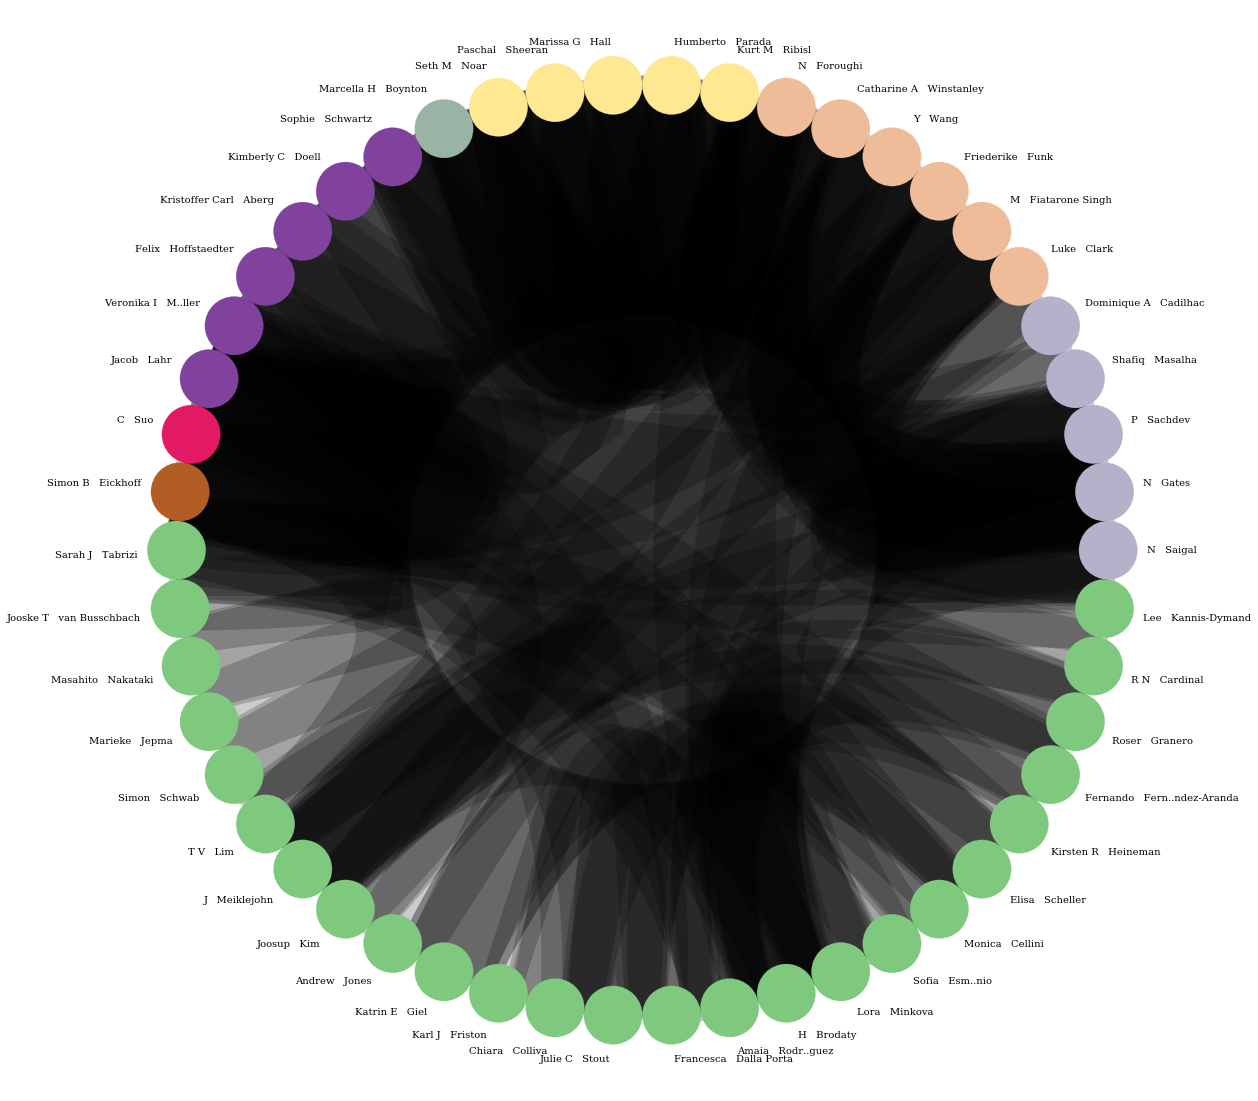

In [35]:
split_author = lambda rank : [[str(y.strip()) for y in x.split('|')] for x in rank]

# return a list of authors
authors_flat = [
    author
    for authors in split_author(copy["author"])
    for author in authors
]


authors = split_author(copy["author"])

# flatten list function

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

# Extract author connections
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = flatten_list(author_connections)

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.node[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

In [36]:
plt.savefig(circ_name)

<Figure size 432x288 with 0 Axes>

Image is saved in the relevant folder.

#### Network analysis of authors

Which researcher has the most collaborations?
Who is essential in connecting to the other authors.

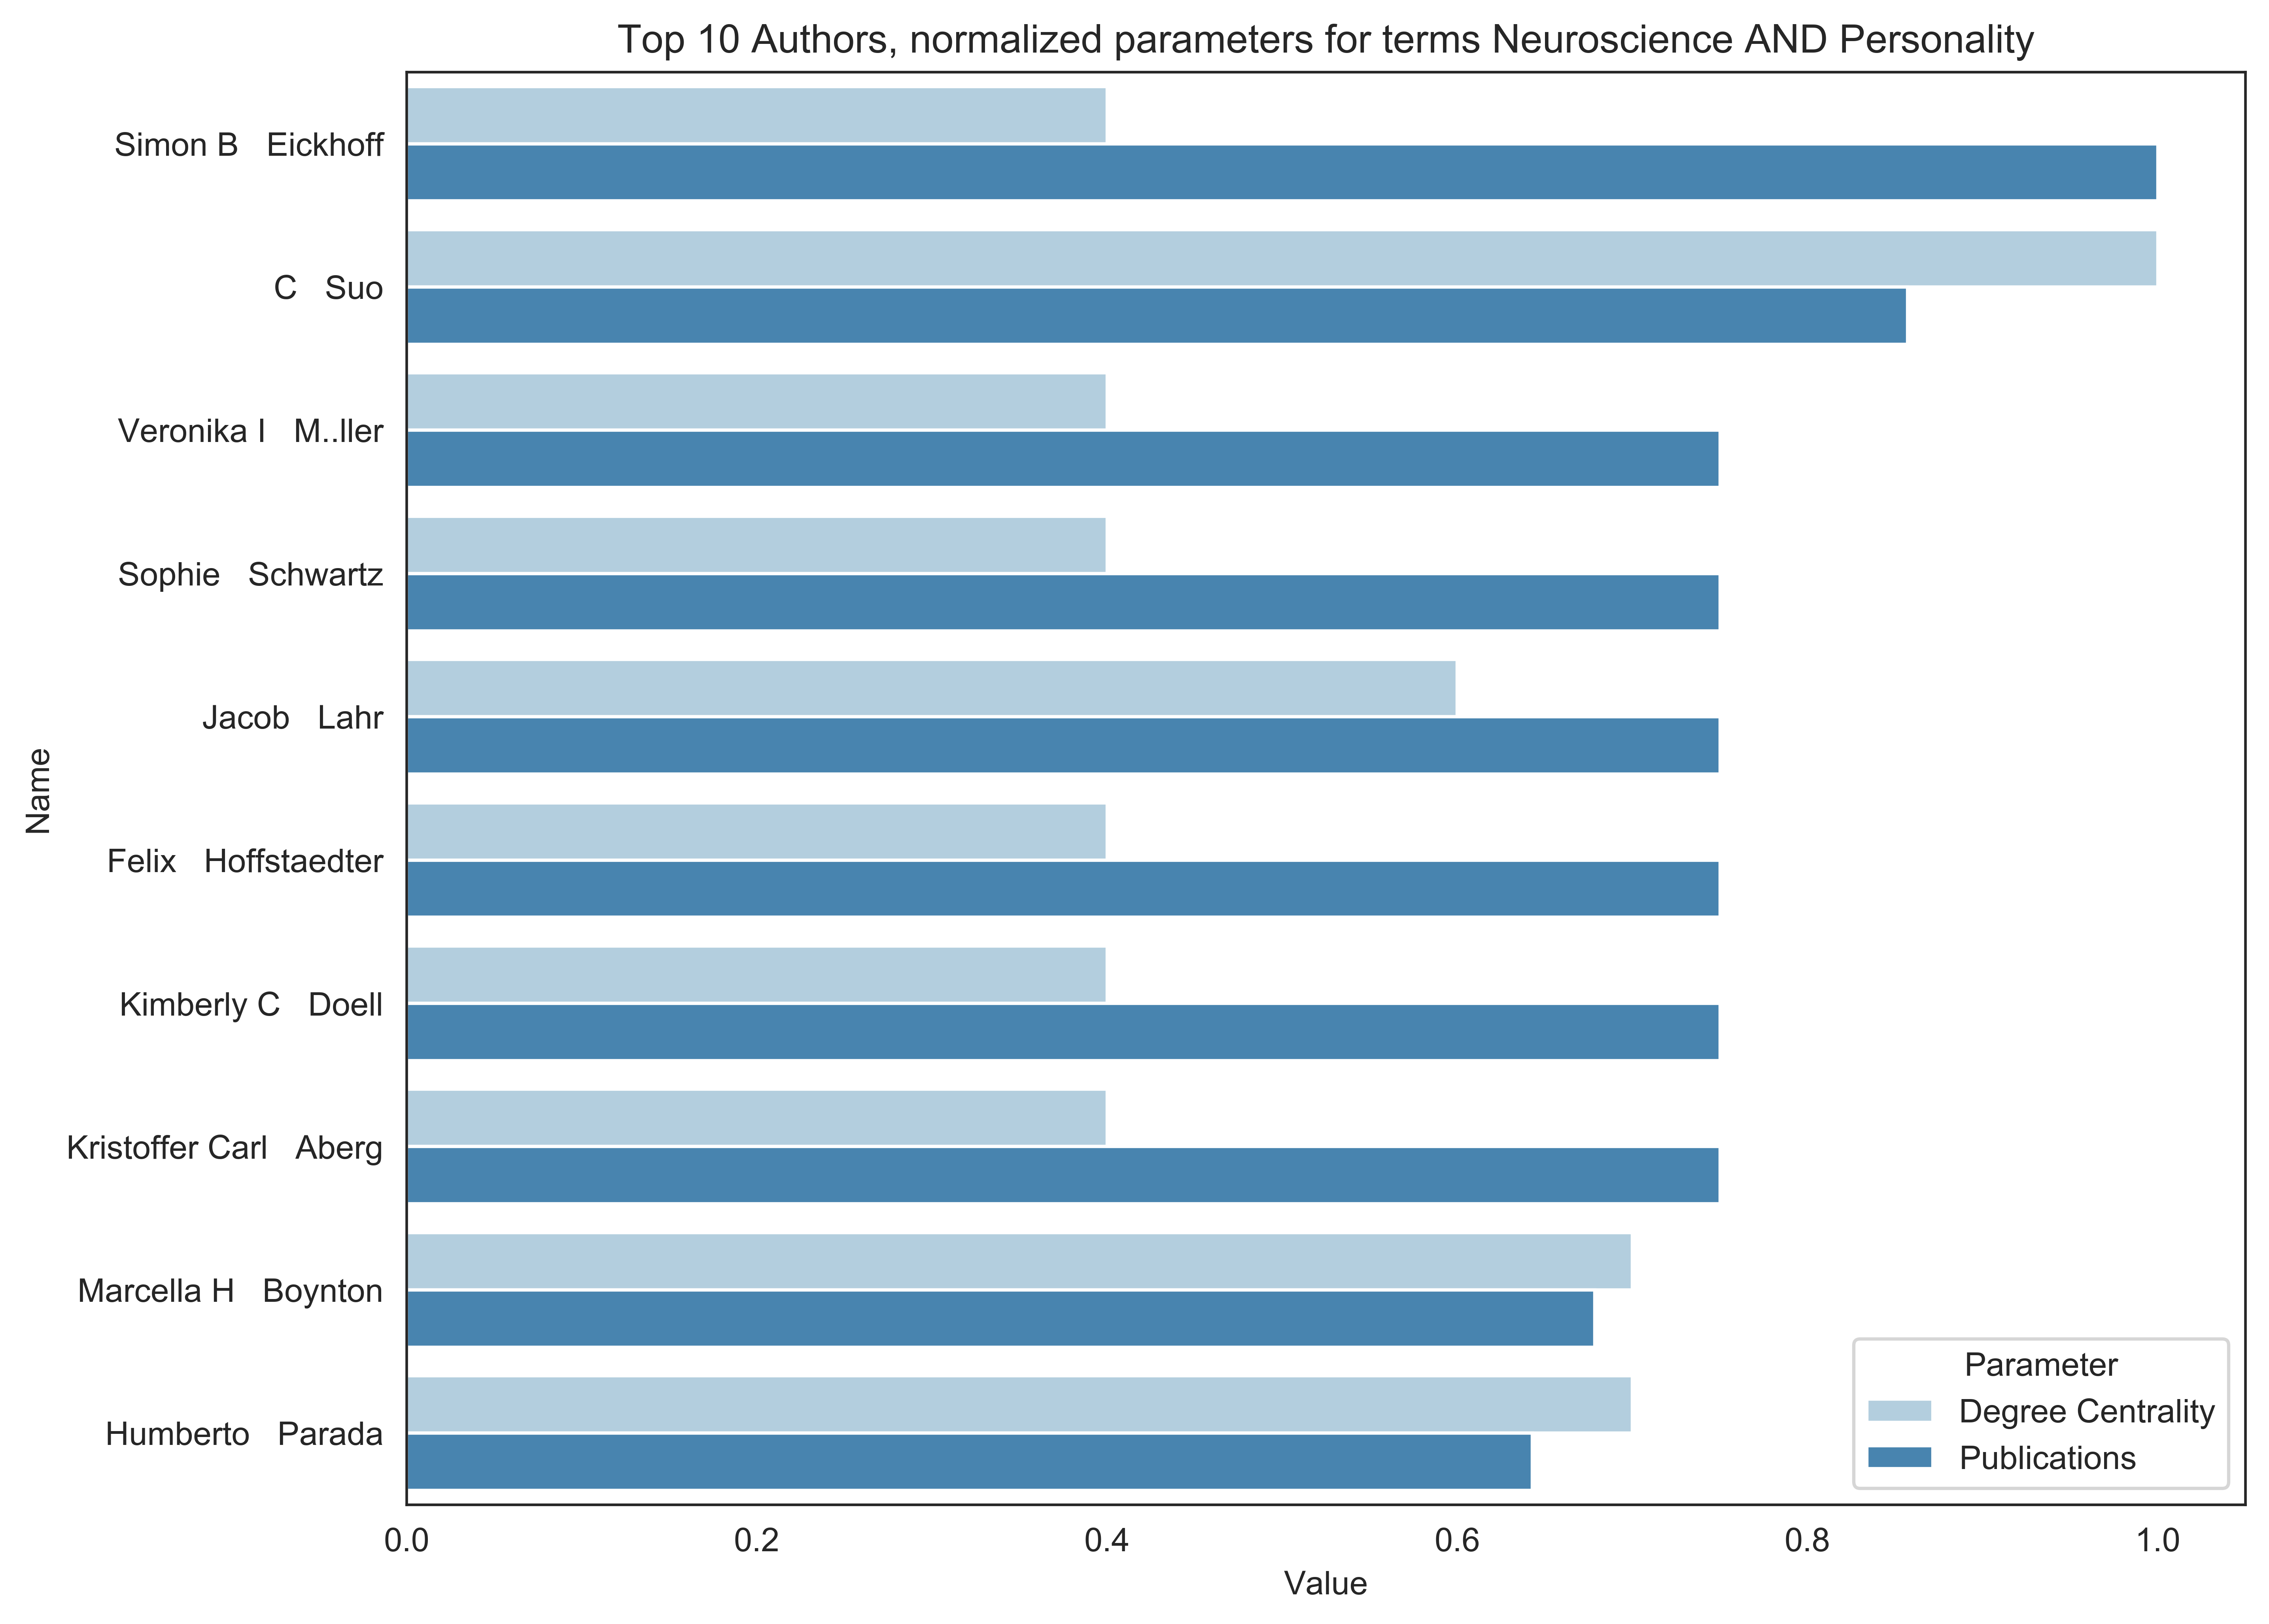

In [37]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters for terms {}".format(terms))
plt.show()

In [38]:
betweeness_name = circ_name.strip('.jpeg') + '_between.jpeg'
plt.savefig(betweeness_name)

<Figure size 432x288 with 0 Axes>

***